# Build a Deep Face Detection Model with Python and Tensorflow

In [1]:
# !pip install labelme opencv-python matplotlib albumentations

In [2]:
import os
import time
import uuid
import cv2

####  Collect Images Using OpenCV

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

####  Annotate Images with LabelMe

In [5]:
# !labelme

## Review Dataset and Build Image Loading Function

#### Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### Load Image into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [8]:
images.as_numpy_iterator().next()

b'data\\images\\5f3b609c-b543-11ed-b101-c45444118847.jpg'

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [12]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

#### View Raw Images with Matplotlib

In [13]:
image_generator = images.batch(4).as_numpy_iterator()

In [14]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## Partition Unaugmented Data

####  MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [16]:
60*.7 # 42 to train

42.0

In [17]:
60*0.15 # 9 and 9 to test and val

9.0

### Move the Matching Labels

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

## Apply Image Augmentation on Images and Labels using Albumentations

### Setup Albumentations Transform Pipeline

In [19]:
import albumentations as alb

In [20]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Load a Test Image and Annotation with OpenCV and JSON

In [21]:
img = cv2.imread(os.path.join('data','train', 'images','1866a028-b3a3-11ed-851f-c45444118847.jpg'))

In [22]:
with open(os.path.join('data', 'train', 'labels', '1866a028-b3a3-11ed-851f-c45444118847.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label

In [ ]:
label['shapes'][0]['points']

### Extract Coordinates and Rescale to Match Image Resolution

In [25]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [26]:
coords

[133.50364963503648, 82.33576642335767, 421.0948905109489, 414.45255474452557]

In [27]:
coords = list(np.divide(coords, [640,480,640,480]))

In [28]:
coords

[0.2085994525547445,
 0.17153284671532848,
 0.6579607664233577,
 0.8634428223844283]

##  Apply Augmentations and View Results

In [29]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [30]:
augmented['bboxes'][0][2:]

(0.8366585563665856, 0.8587834549878346)

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

### Run Augmentation Pipeline

In [33]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### Load Augmented Images to Tensorflow Dataset

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [35]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [36]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

# Prepare Labels

### Build Label Loading Function

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### Load Labels to Tensorflow Dataset

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

# Combine Label and Image Samples

### Check Partition Lengths

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2520, 2520, 660, 660, 600, 600)

### Create Final Datasets (Images/Labels)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [45]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

#  View Images and Annotations

In [48]:
data_samples = train.as_numpy_iterator()

In [49]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning using the Functional API

### Import Layers and Base Network

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG16

In [52]:
vgg = VGG16(include_top=False)

In [53]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build instance of Network

In [54]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### Test out Neural Network

In [55]:
facetracker = build_model()

In [56]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [57]:
X, y = train.as_numpy_iterator().next()

In [58]:
X.shape

(8, 120, 120, 3)

In [59]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [ ]:
classes, coords

# Define Losses and Optimizers

### Define Optimizer and LR

In [61]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [62]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

### Create Localization Loss and Classification Loss

In [63]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [64]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### Test out Loss Metrics

In [65]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7183256>

In [66]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5785824>

In [67]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7183256>

# Train Neural Network

###  Create Custom Model Class

In [68]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [69]:
model = FaceTracker(facetracker)

In [70]:
model.compile(opt, classloss, regressloss)

### Train

In [71]:
logdir='logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [73]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
315/315 [==============================] - 6887s 22s/step - total_loss: 0.3136 - class_loss: 0.0696 - regress_loss: 0.2788 - val_total_loss: 0.1174 - val_class_loss: 0.0299 - val_regress_loss: 0.1024
Epoch 2/10
315/315 [==============================] - 5084s 16s/step - total_loss: 0.1007 - class_loss: 0.0257 - regress_loss: 0.0879 - val_total_loss: 1.5521 - val_class_loss: 0.5696 - val_regress_loss: 1.2673
Epoch 3/10
315/315 [==============================] - 4927s 16s/step - total_loss: 0.1137 - class_loss: 0.0305 - regress_loss: 0.0985 - val_total_loss: 0.0632 - val_class_loss: 0.0061 - val_regress_loss: 0.0601
Epoch 4/10
315/315 [==============================] - 4999s 16s/step - total_loss: 0.0609 - class_loss: 0.0095 - regress_loss: 0.0561 - val_total_loss: 0.7542 - val_class_loss: 0.2229 - val_regress_loss: 0.6428
Epoch 5/10
315/315 [==============================] - 4980s 16s/step - total_loss: 0.0361 - class_loss: 0.0070 - regress_loss: 0.0326 - val_total_loss: 1.77

#### Plot Performance

In [74]:
hist.history

{'total_loss': [0.12007973343133926,
  0.044627975672483444,
  0.021967953070998192,
  0.033700671046972275,
  0.014439842663705349,
  0.02552909404039383,
  0.1109016090631485,
  0.03604573756456375,
  0.01881798729300499,
  0.03355016931891441],
 'class_loss': [0.00028944824589416385,
  0.0008446713327430189,
  0.00019939529011026025,
  7.33034685254097e-05,
  0.0001635591615922749,
  0.00020315952133387327,
  0.04633855074644089,
  0.00031969131669029593,
  0.00011423132673371583,
  0.00018694472964853048],
 'regress_loss': [0.11993500590324402,
  0.04420563951134682,
  0.021868254989385605,
  0.03366401791572571,
  0.014358063228428364,
  0.02542751468718052,
  0.08773233741521835,
  0.03588589280843735,
  0.01876087114214897,
  0.033456698060035706],
 'val_total_loss': [0.11738970130681992,
  1.552139401435852,
  0.06317727267742157,
  0.7542126178741455,
  1.7798848152160645,
  1.9687974452972412,
  0.04755260795354843,
  0.18845213949680328,
  2.5462517738342285,
  0.44609749317

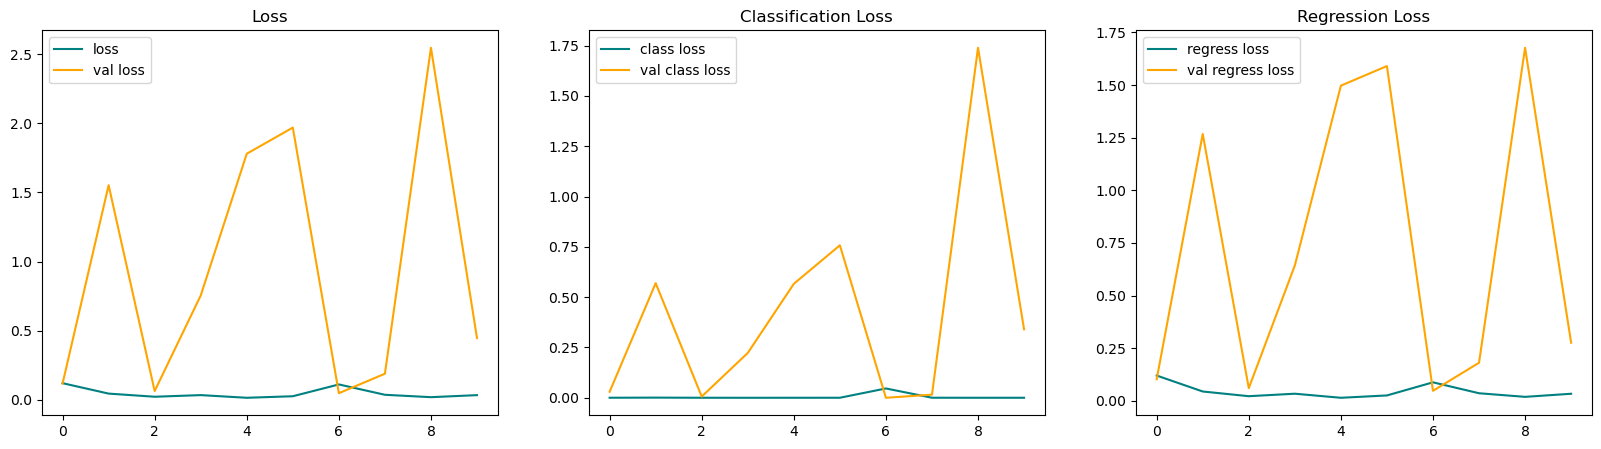

In [75]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


# Make Predictions

#### Make Predictions on Test Set

In [76]:
test_data = test.as_numpy_iterator()

In [77]:
test_sample = test_data.next()

In [78]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 5s 5s/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

#### Save the Model

In [80]:
from tensorflow.keras.models import load_model

In [81]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()